In [71]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from cgmsquared import clustering as cgm2_cluster
import haloclustering.evalulate_model as evaluate
import emcee
import corner
import pandas as pd
import scipy.special as sc
from astropy.cosmology import Planck15 as cosmo
import haloclustering.plot as hplt
import haloclustering.data as datamodule

from multiprocessing import Pool
from multiprocessing import cpu_count
import seaborn as sns

from scipy.stats import binned_statistic

plt.rcParams['font.serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 16
from haloclustering import models
from astropy.stats import binned_binom_proportion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
# get data
df = pd.read_csv('../data/cgm2_casbah_velo_split_table_with_comoving_rho_and_mass.csv')
df['log_rho'] = np.log10(df.rho)
df.sort_values('rho', inplace=True)
# df.rho = df.rho / 1000 # convert to Mpc
df = df.query("(HM_0_500 != 'indeterminate') & (7 < mstars < 12)")
df['Hz'] = cosmo.H(df.z).value
vmax = 500.0 # km/s

df.dropna(subset=['mstars'], inplace=True)
massmask = df.eval("8 < mstars < 10.5").values
df['logm'] = df.mstars
df.mstars = 10**df.mstars


outcomes = df.HM_0_500
hits = (outcomes.values == "hit") & massmask
misses = (outcomes.values == "miss") & massmask


In [154]:
df

,Name,z,rho,ang_sep,RA,DEC,cosmo,CreationDate,user,HM_0_500,...,HM_300_400,HM_400_500,mstars,rvir,rho_rvir,gal_type,z_igmsys,log_rho,Hz,logm
0,J1553+3548_318_10,0.082712,16.619888,9.550870,238.268341,35.809929,Planck15,2021-Mar-15,mwilde,miss,...,miss,miss,6.937474e+08,130.879303,0.117270,SF,0.082555,1.220628,70.501571,8.841201
1,J1437+5045_206_41,0.018490,17.659946,41.247617,219.350861,50.755249,Planck15,2021-Mar-15,mwilde,miss,...,miss,miss,2.769265e+07,85.604588,0.202570,SF,0.018850,1.246989,68.328814,7.442364
2,J1133+0327_111_5,0.236701,22.505146,4.697760,173.367000,3.454861,Planck15,2021-Mar-15,mwilde,hit,...,hit,miss,9.364114e+10,523.891170,0.032816,E,0.237347,1.352282,76.503721,10.971467
3,J1241+5721_200_6,0.205262,26.595202,6.350156,190.474000,57.350389,Planck15,2021-Mar-15,mwilde,hit,...,miss,miss,8.063705e+09,183.087643,0.117362,SF,0.205592,1.424803,75.189212,9.906535
4,J1133+0327_105_6,0.236691,27.860515,5.815880,173.367340,3.454900,Planck15,2021-Mar-15,mwilde,hit,...,hit,miss,1.919739e+11,1076.360645,0.020930,SF+E,0.237347,1.444989,76.503294,11.283242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7387,J0235-0402_189_2356,0.438236,19807.272123,2356.020207,38.683218,-4.682089,Planck15,2021-Mar-28,jnburchett,miss,...,miss,miss,5.164852e+10,NaN,NaN,NaN,0.440730,4.296825,85.962183,10.713058
7388,J0751+2919_56_3394,0.293134,19838.578641,3393.559141,118.704501,29.848535,Planck15,2021-Mar-09,jnburchett,miss,...,miss,miss,2.014072e+08,NaN,NaN,NaN,0.294790,4.297511,78.974832,8.304075
7389,J1208+4540_184_3014,0.335515,19944.141856,3014.296823,182.162328,44.841086,Planck15,2021-Mar-28,jnburchett,hit,...,miss,miss,3.385574e+10,NaN,NaN,NaN,0.335860,4.299815,80.922923,10.529632
7390,J0751+2919_325_2204,0.477202,19961.539413,2203.667910,117.392278,29.825473,Planck15,2021-Mar-09,jnburchett,miss,...,miss,miss,1.806679e+09,NaN,NaN,NaN,0.475676,4.300194,87.987543,9.256881


In [155]:
dfnew = df.copy()

<Figure size 720x504 with 0 Axes>

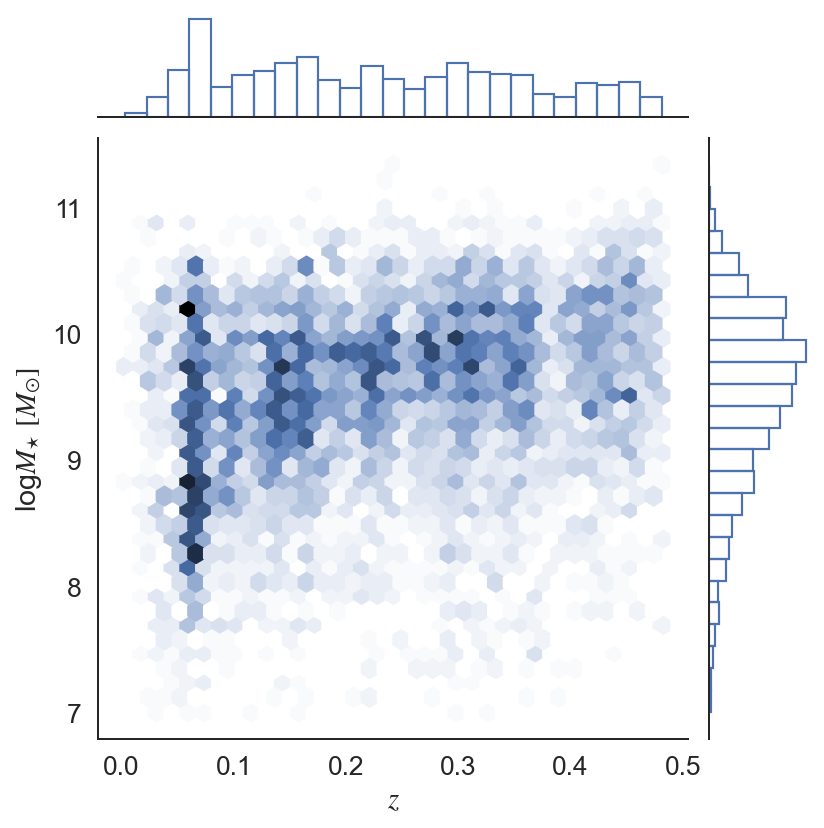

In [177]:
joint_kws=dict(gridsize=30)
plt.figure(figsize=(10,7))


# df.sort_values("survey", inplace=True)


sns.set_theme(style="ticks")
s = [r'$z$', r'log$M_{\star}$ $[M_{\odot}]$']
with sns.axes_style('white'):
    sns.set_context("paper", font_scale=1.5)

    g = sns.jointplot(data=df, 
                      x="z", y="logm",
                      kind="hex",
                      marginal_kws=dict(bins=25, fill=False))

    g.set_axis_labels(s[0], s[1])
    plt.savefig('combined_data_mass_z.png');

<Figure size 720x504 with 0 Axes>

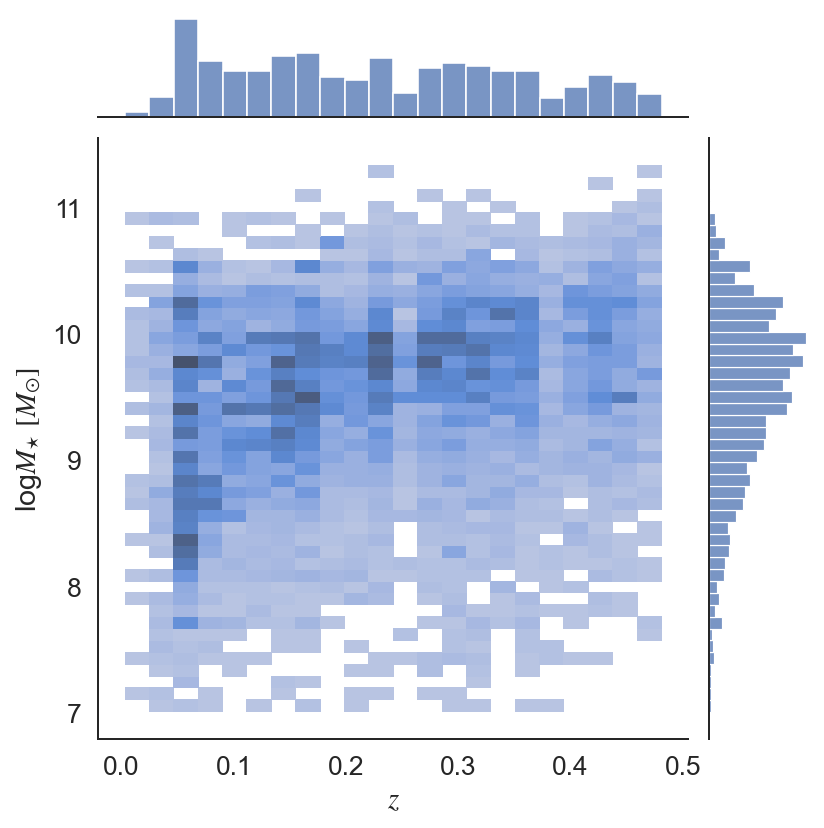

In [179]:
joint_kws=dict(gridsize=30)
plt.figure(figsize=(10,7))


# df.sort_values("survey", inplace=True)


sns.set_theme(style="ticks")
s = [r'$z$', r'log$M_{\star}$ $[M_{\odot}]$']
with sns.axes_style('white'):
    sns.set_context("paper", font_scale=1.5)

    g = sns.jointplot(data=df, 
                      x="z", y="logm",
                      kind="hist")

    g.set_axis_labels(s[0], s[1])
    # plt.savefig('combined_data_mass_z.png');

In [157]:
def log_probability(params, rho_gal_com, z_gal, Hz, vmax, hits, misses, mass):
    r0, gamma, beta2h, A, r_cross, beta1h, dndz_index, dndz_coeff = params
    lp = log_prior(params)

    if not np.isfinite(lp):
        return -np.inf, np.full(mass.shape, np.nan)
    logl, prob_hit = log_likelihood(r0, gamma, beta2h, A, r_cross, beta1h, dndz_index, dndz_coeff, rho_gal_com, z_gal, Hz, vmax, mass, hits, misses)
    logprob = lp + logl
    return logprob, prob_hit

In [164]:
import pickle
pkl_file = '../exclusion-model/exclusion_model_gauss_1h_sampler.pkl'
infile = open(pkl_file, "rb")
sampler = pickle.load(infile)
infile.close()

In [165]:
import pickle
pkl_file = '../exclusion-model/model_2h_w_beta_sampler.pkl'
infile = open(pkl_file, "rb")
sampler_2h = pickle.load(infile)
infile.close()

In [166]:
df['cf_model'] = np.nanmean(sampler.blobs, axis=(0,1))
df['cf_model_2h'] = np.nanmean(sampler_2h.blobs, axis=(0,1))

260
1368
3816
1790


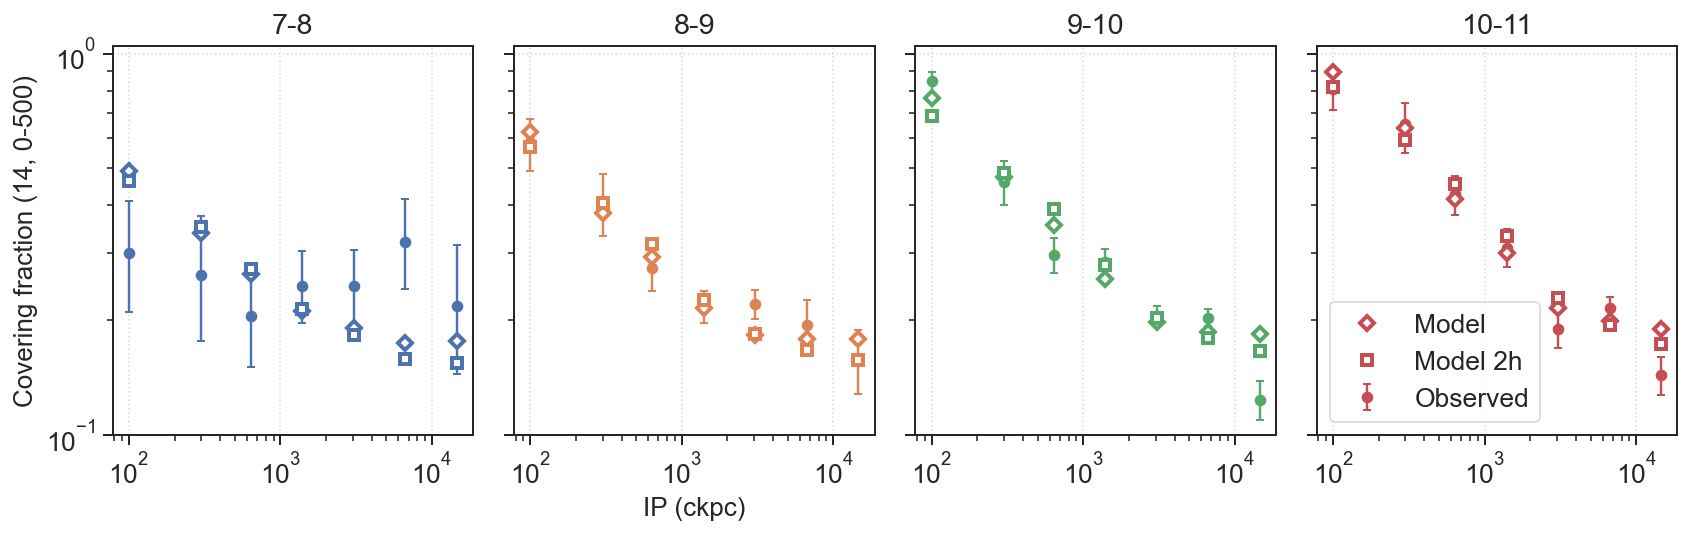

In [170]:
#rho_bins = np.concatenate([[0], np.geomspace(100, 20e3, 11)])

rho_bins = np.concatenate([[0, 200], np.geomspace(400, 20e3, 6)])
#rho_bins = np.concatenate([[0], np.geomspace(100, 20e3, 11)])

bin_ctr = 0.5*(rho_bins[1:] + rho_bins[:-1])
#rho_bins = np.geomspace(20, 20e3, 15)
#np.concatenate([[0, 100, 200], np.geomspace(300, 20e3, 7)])
plt.close("all")

fig, axes = plt.subplots(1, 4, figsize=[12, 4], sharex=True, sharey=True)

hm = 'HM_0_500'

if True:
    rngs = [[7, 8], [8, 9], [9, 10], [10, 11]]
else:
    rngs = [[8, 9], [9, 10], [10, 11]]

for e, (ax, rng) in enumerate(zip(axes, rngs)):
    ssdf = df.query(f'({rng[0]} < logm < {rng[1]})').copy()
    print(ssdf.__len__())
    ssdf['is_hit'] = np.where(ssdf[hm]=='hit', True, False)
    
    bin_ctr_p, _, p, perr = binned_binom_proportion(ssdf.rho.values, ssdf.is_hit.values, bins=rho_bins,
                                                 interval='jeffreys')
    ax.errorbar(bin_ctr_p, p, yerr=perr, ls='none', marker='o', label='Observed'.format(*rng), capsize=2,
                color='C{}'.format(e))
    model = binned_statistic(ssdf.rho.values, ssdf.cf_model.values, bins=rho_bins, )
    model_2h = binned_statistic(ssdf.rho.values, ssdf.cf_model_2h.values, bins=rho_bins, )
    ax.plot(bin_ctr, model[0], marker='D', mfc='white', mec='C{}'.format(e), mew=2, ls='none', label='Model',
           zorder=5)
    ax.plot(bin_ctr, model_2h[0], marker='s', mfc='white', mec='C{}'.format(e), mew=2, ls='none', label='Model 2h',
        zorder=5)
        
    ax.set_title('{}-{}'.format(*rng))
    ax.grid(ls=':', color='gainsboro')
plt.legend()
plt.xscale('log');

if True:
    plt.yscale('log')
    plt.ylim(1e-1, 1.05)
else:
    plt.ylim(-0.05, 1.05)
axes[1].set_xlabel('IP (ckpc)', fontsize=13)
axes[0].set_ylabel('Covering fraction ({}, 0-500)'.format(14), fontsize=13);

plt.tight_layout();
#plt.savefig('cf_plots/{}_{}_coarse.pdf'.format(model, ltNH_thresh))

260
1368
3816
1790


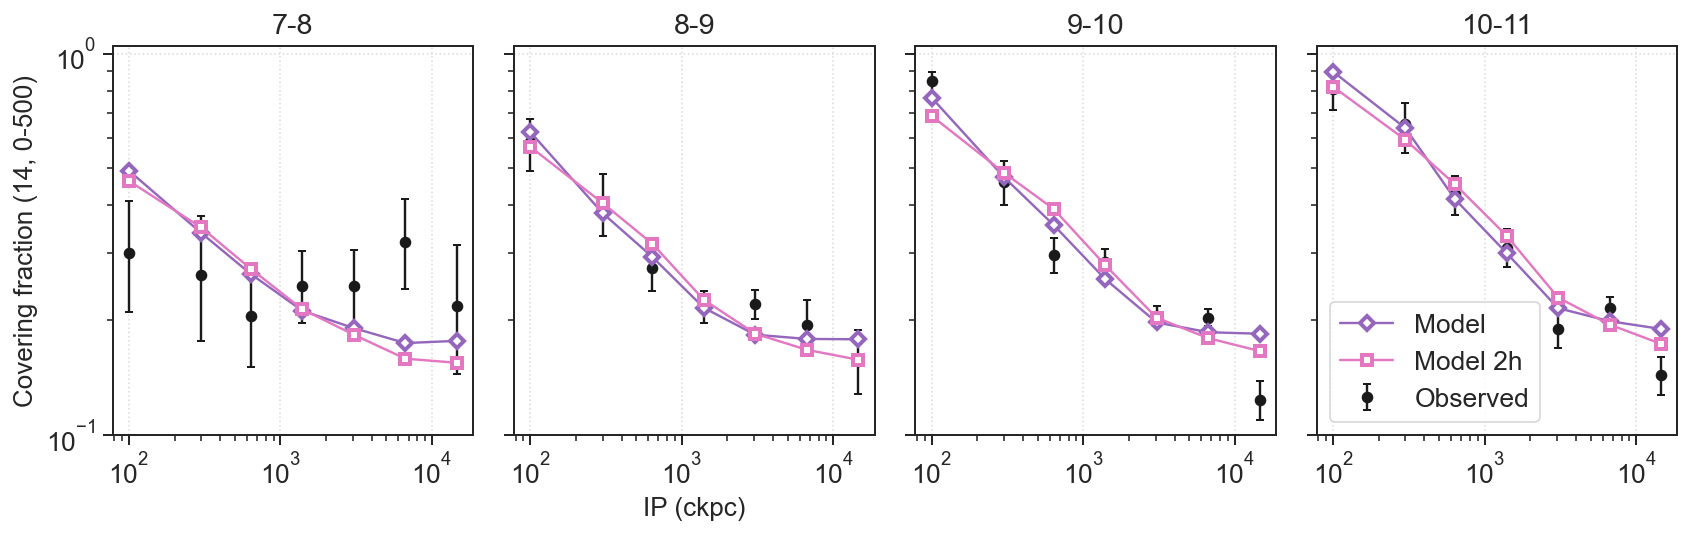

In [174]:
#rho_bins = np.concatenate([[0], np.geomspace(100, 20e3, 11)])

rho_bins = np.concatenate([[0, 200], np.geomspace(400, 20e3, 6)])
#rho_bins = np.concatenate([[0], np.geomspace(100, 20e3, 11)])

bin_ctr = 0.5*(rho_bins[1:] + rho_bins[:-1])
#rho_bins = np.geomspace(20, 20e3, 15)
#np.concatenate([[0, 100, 200], np.geomspace(300, 20e3, 7)])
plt.close("all")

fig, axes = plt.subplots(1, 4, figsize=[12, 4], sharex=True, sharey=True)

hm = 'HM_0_500'

if True:
    rngs = [[7, 8], [8, 9], [9, 10], [10, 11]]
else:
    rngs = [[8, 9], [9, 10], [10, 11]]

for e, (ax, rng) in enumerate(zip(axes, rngs)):
    ssdf = df.query(f'({rng[0]} < logm < {rng[1]})').copy()
    print(ssdf.__len__())
    ssdf['is_hit'] = np.where(ssdf[hm]=='hit', True, False)
    
    bin_ctr_p, _, p, perr = binned_binom_proportion(ssdf.rho.values, ssdf.is_hit.values, bins=rho_bins,
                                                 interval='jeffreys')
    ax.errorbar(bin_ctr_p, p, yerr=perr, ls='none', marker='o', label='Observed'.format(*rng), capsize=2,
                color='k')
    model = binned_statistic(ssdf.rho.values, ssdf.cf_model.values, bins=rho_bins, )
    model_2h = binned_statistic(ssdf.rho.values, ssdf.cf_model_2h.values, bins=rho_bins, )
    ax.plot(bin_ctr, model[0], marker='D', mfc='white', mec='tab:purple', mew=2, ls='-', c='tab:purple', label='Model',
           zorder=5)
    ax.plot(bin_ctr, model_2h[0], marker='s', mfc='white', mec='tab:pink', mew=2, ls='-', c='tab:pink', label='Model 2h',
        zorder=5)
        
    ax.set_title('{}-{}'.format(*rng))
    ax.grid(ls=':', color='gainsboro')
plt.legend()
plt.xscale('log');

if True:
    plt.yscale('log')
    plt.ylim(1e-1, 1.05)
else:
    plt.ylim(-0.05, 1.05)
axes[1].set_xlabel('IP (ckpc)', fontsize=13)
axes[0].set_ylabel('Covering fraction ({}, 0-500)'.format(14), fontsize=13);

plt.tight_layout();
#plt.savefig('cf_plots/{}_{}_coarse.pdf'.format(model, ltNH_thresh))